# Useful Imports

In [1]:
import torch
from transformers import utils, CLIPProcessor, CLIPModel, GPT2LMHeadModel, GPT2Tokenizer
from PIL import Image

c:\Users\moote\.conda\envs\image_captioning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# At least v2.6
print(utils.import_utils.get_torch_version())

2.7.1+cu126


# Import Models

In [3]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") # torch at least v2.6 is required otherwise this will throw ValueError: Due to a serious vulnerability issue in torch.load, even with weights_only=True, we now require users to upgrade torch to at least v2.6 in order to use the function.
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
clip_model = clip_model.to(device)
gpt2_model = gpt2_model.to(device)

cuda


# Import a random Image

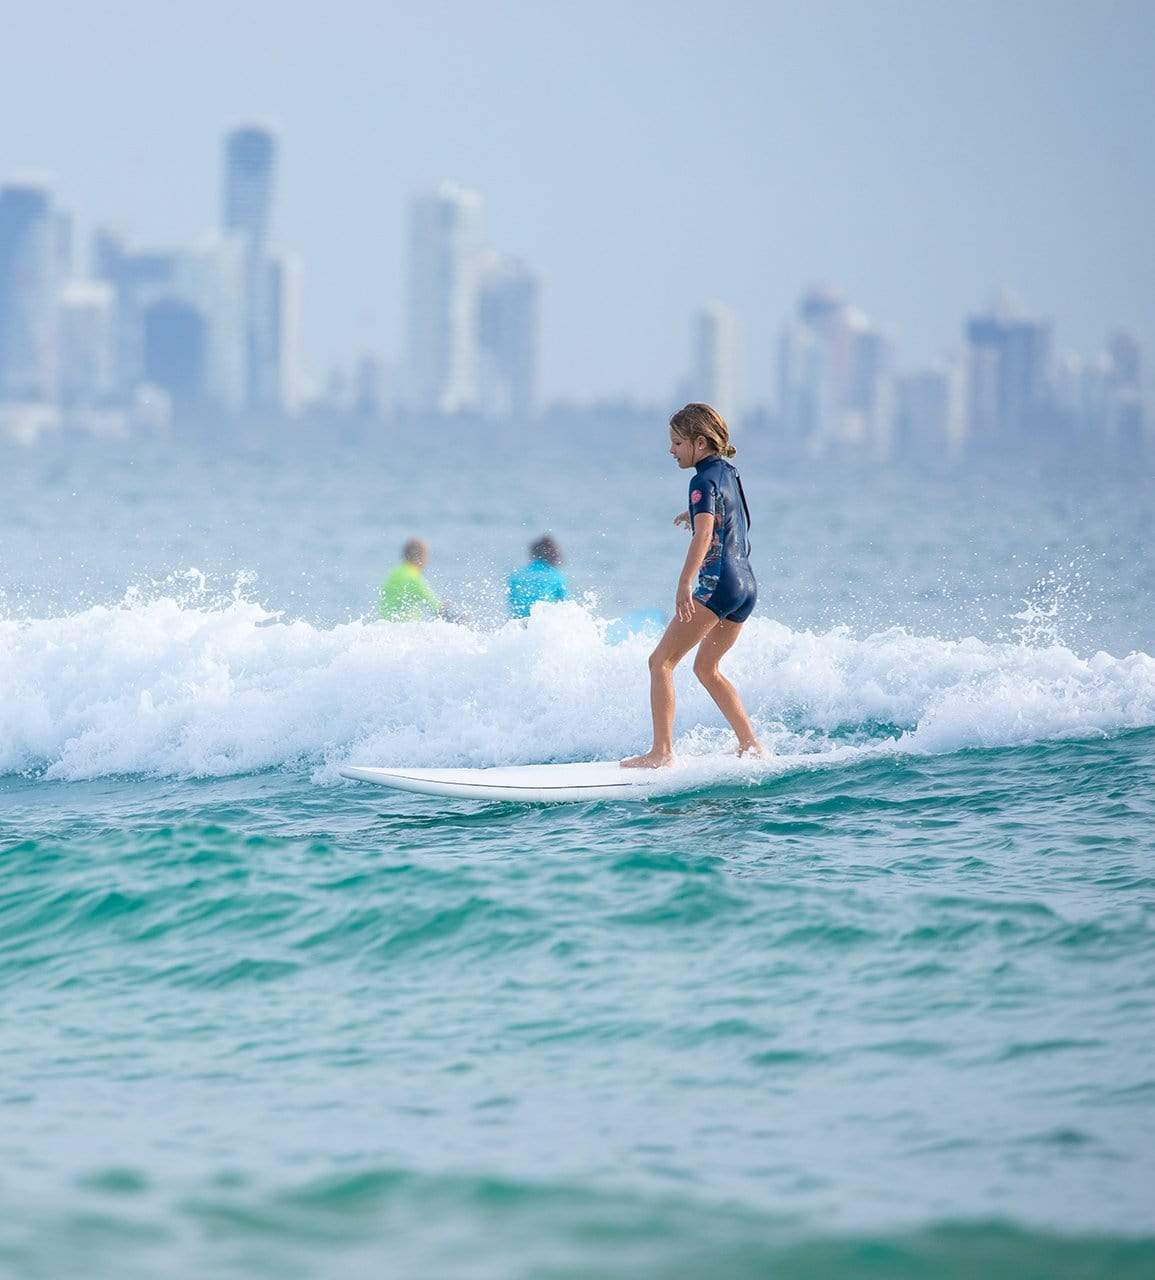

In [5]:
image = Image.open("random_image.jpg").convert("RGB")
image

# Generate Embeddings

## CLIP Embedding

In [6]:
# CLIP Embedding
clip_inputs = clip_processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    clip_embed = clip_model.get_image_features(**clip_inputs)
print(clip_embed.shape)

torch.Size([1, 512])


## Project to get GPT2 Embedding

In [7]:
projection = torch.nn.Linear(clip_embed.shape[-1], gpt2_model.config.n_embd).to(device)
with torch.no_grad():
    gpt_embed = projection(clip_embed).unsqueeze(1)
print(gpt_embed.shape)

torch.Size([1, 1, 768])


# Generate Caption

In [8]:
# Begining of the sequence token
input_ids = torch.tensor([[gpt2_tokenizer.bos_token_id]]).to(device)
print(input_ids)

tensor([[50256]], device='cuda:0')


In [9]:
for _ in range(30):  # max caption length in tokens
    with torch.no_grad():
        token_embeddings = gpt2_model.transformer.wte(input_ids)
        gpt_inputs = torch.cat([gpt_embed, token_embeddings], dim=1)
        outputs = gpt2_model(inputs_embeds=gpt_inputs)
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
    
    if next_token.item() == gpt2_tokenizer.eos_token_id:
        break
    
    input_ids = torch.cat([input_ids, next_token], dim=1)

In [10]:
caption = gpt2_tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)
print("🖼️ Caption:", caption)

🖼️ Caption: The U.S. Department of Justice has filed a lawsuit against the company that owns the video game company, Electronic Arts, alleging that the company's
